# Spark configuration

In [ ]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
spark.version

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1684737042965_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'3.0.1-amzn-0'

In [3]:
sc.list_packages()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version   
-------------------------- ----------
beautifulsoup4             4.9.3     
boto                       2.49.0    
click                      7.1.2     
jmespath                   0.10.0    
joblib                     0.17.0    
lxml                       4.6.1     
mysqlclient                1.4.2     
nltk                       3.5       
nose                       1.3.4     
numpy                      1.16.5    
pip                        9.0.1     
py-dateutil                2.2       
python37-sagemaker-pyspark 1.4.1     
pytz                       2020.1    
PyYAML                     5.3.1     
regex                      2020.10.28
setuptools                 28.8.0    
six                        1.13.0    
tqdm                       4.51.0    
wheel                      0.29.0    
windmill                   1.6

In [ ]:
%%capture
# install packages
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pybind11")
sc.install_pypi_package("scipy==1.2.1")
sc.install_pypi_package("statsmodels==0.12.0")
sc.install_pypi_package("boto3==1.18.21")

# Load transactions data

To see block-level data directly, query the 'blocks' table (code below). However this table does not include information on the aggregate transaction fees in the block, only gas units.

In [5]:
"""
from pyspark.sql.functions import col

blocks = spark.read.parquet("s3://aws-public-blockchain/v1.0/eth/blocks/") \
                    .where(col('date').between(start_date, end_date))
"""

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\nfrom pyspark.sql.functions import col\n\nblocks = spark.read.parquet("s3://aws-public-blockchain/v1.0/eth/blocks/")                     .where(col(\'date\').between(start_date, end_date))\n'

So instead, I query the 'transactions' table and then aggregate into block level.

In [6]:
from pyspark.sql.functions import col

start_date = '2021-09-01'
end_date = '2023-05-01'
raw = spark.read.parquet("s3://aws-public-blockchain/v1.0/eth/transactions/") \
                    .where(col('date').between(start_date, end_date))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
raw.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+--------------------+--------------------+-----+-----------+------------+--------------------+-----------------+--------------------+--------------------+-----------+---------------------------+----------------+------------------------+--------------+---------------------------+----------------+---------------+------------------------+-------------------+----------+--------------------+
|   gas|                hash|               input|nonce|      value|block_number|          block_hash|transaction_index|        from_address|          to_address|  gas_price|receipt_cumulative_gas_used|receipt_gas_used|receipt_contract_address|receipt_status|receipt_effective_gas_price|transaction_type|max_fee_per_gas|max_priority_fee_per_gas|    block_timestamp|      date|       last_modified|
+------+--------------------+--------------------+-----+-----------+------------+--------------------+-----------------+--------------------+--------------------+-----------+---------------------------+--

In [8]:
# columns related to gas
raw.select(['date','hash','gas', 'gas_price', 
             'receipt_cumulative_gas_used','receipt_gas_used',
             'receipt_effective_gas_price']).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+-------+-----------+---------------------------+----------------+---------------------------+
|      date|                hash|    gas|  gas_price|receipt_cumulative_gas_used|receipt_gas_used|receipt_effective_gas_price|
+----------+--------------------+-------+-----------+---------------------------+----------------+---------------------------+
|2023-01-30|0xbfe1a445e748cea...|  60000|60000000000|                      58824|           58824|                60000000000|
|2023-01-30|0xd64a068992d578b...|  80000|30000000000|                      98660|           39836|                30000000000|
|2023-01-30|0xa2e467191648933...| 101440|21600000000|                     144769|           46109|                21600000000|
|2023-01-30|0x5a0ac86debda3b4...| 219514|20726344000|                     263126|          118357|                20726344000|
|2023-01-30|0x9d9a3d911488516...| 850000|20229607745|                     467323|          204197|             

Above are all fields related to transaction fee (gas fee).  
Ethereum gas fees are computed using gas units * gas price. Prices are in wei/unit and 1 ETH = 10^18 wei.  
gas, gas_price: values when transaction was initiated  
receipt_gas_used, receipt_effective_gas_price: values calculated when settling transaction  
I will use the second pair for calculating transaction fee ex-post. 


# Transaction fee feature / Aggregation

In [9]:
# calculate transaction fee in eth
df = raw.withColumn('txn_fee', raw.receipt_gas_used * raw.receipt_effective_gas_price / 1.0e18)
df.select(['date', 'hash','txn_fee']).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+--------------------+
|      date|                hash|             txn_fee|
+----------+--------------------+--------------------+
|2023-01-30|0xbfe1a445e748cea...|          0.00352944|
|2023-01-30|0xd64a068992d578b...|          0.00119508|
|2023-01-30|0xa2e467191648933...|         9.959544E-4|
|2023-01-30|0x5a0ac86debda3b4...|   0.002453107896808|
|2023-01-30|0x9d9a3d911488516...|0.004130825212705765|
|2023-01-30|0x891cc7766e6188e...|           0.0687143|
|2023-01-30|0x7d6fd5f03ae86b3...|0.002455024791196405|
|2023-01-30|0x3e4fd6fee597891...|0.002254729196924485|
|2023-01-30|0x28e8cfface36978...|0.002254729196924485|
|2023-01-30|0x149bb99b15e619c...|0.002254729196924485|
+----------+--------------------+--------------------+
only showing top 10 rows

In [10]:
# compute total txn fee for each block
df = df.groupBy(['date','block_timestamp','block_number','block_hash']) \
            .sum('txn_fee') \
            .withColumnRenamed('sum(txn_fee)', 'txn_fee') \
            .sort('block_number')
df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+------------+--------------------+-------------------+
|      date|    block_timestamp|block_number|          block_hash|            txn_fee|
+----------+-------------------+------------+--------------------+-------------------+
|2021-09-01|2021-09-01 00:00:12|    13136427|0x1c3d38ad2873c0f...|  4.500235296531713|
|2021-09-01|2021-09-01 00:00:40|    13136428|0x6426cbb21bddc09...| 1.1043923577333805|
|2021-09-01|2021-09-01 00:00:44|    13136429|0x1025103470c75a6...|0.15909387107386222|
|2021-09-01|2021-09-01 00:00:46|    13136430|0x4cbb6f647eb936c...|  0.977156225798188|
|2021-09-01|2021-09-01 00:00:48|    13136431|0x40aa76a3056da15...|  4.240270822995878|
|2021-09-01|2021-09-01 00:01:24|    13136432|0x40e74037f8fa61a...|  3.940043315604158|
|2021-09-01|2021-09-01 00:01:39|    13136433|0x6813fa509cfc0d1...| 2.1775399984839092|
|2021-09-01|2021-09-01 00:01:40|    13136434|0x90b33d383fb1a25...| 0.8333826916638579|
|2021-09-01|2021-09-01 00:01:45|    1313643

 Further aggregate into daily frequency:

In [11]:
df_daily = df.groupBy('date') \
            .sum('txn_fee') \
            .withColumnRenamed('sum(txn_fee)', 'txn_fee') \
            .sort('date')
df_daily.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+
|      date|           txn_fee|
+----------+------------------+
|2021-09-01|15120.502550905643|
|2021-09-02|11645.607308309774|
|2021-09-03|16008.193498750275|
|2021-09-04|12468.815312722956|
|2021-09-05|11617.029369845292|
|2021-09-06|12226.618501032051|
|2021-09-07| 21057.83448331158|
|2021-09-08|16529.722432752307|
|2021-09-09| 16807.09511707568|
|2021-09-10|10913.772164776334|
+----------+------------------+
only showing top 10 rows

# Exploratory analysis

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
df_pd = df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
len(df_pd)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3626676

In [15]:
plt.figure(figsize=(16,8))
plt.plot(df_pd['block_number'], df_pd['txn_fee'])
plt.title("Ethereum transaction fee by block")
plt.xlabel("Block number")
plt.ylabel("Transaction fee (ETH)")
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

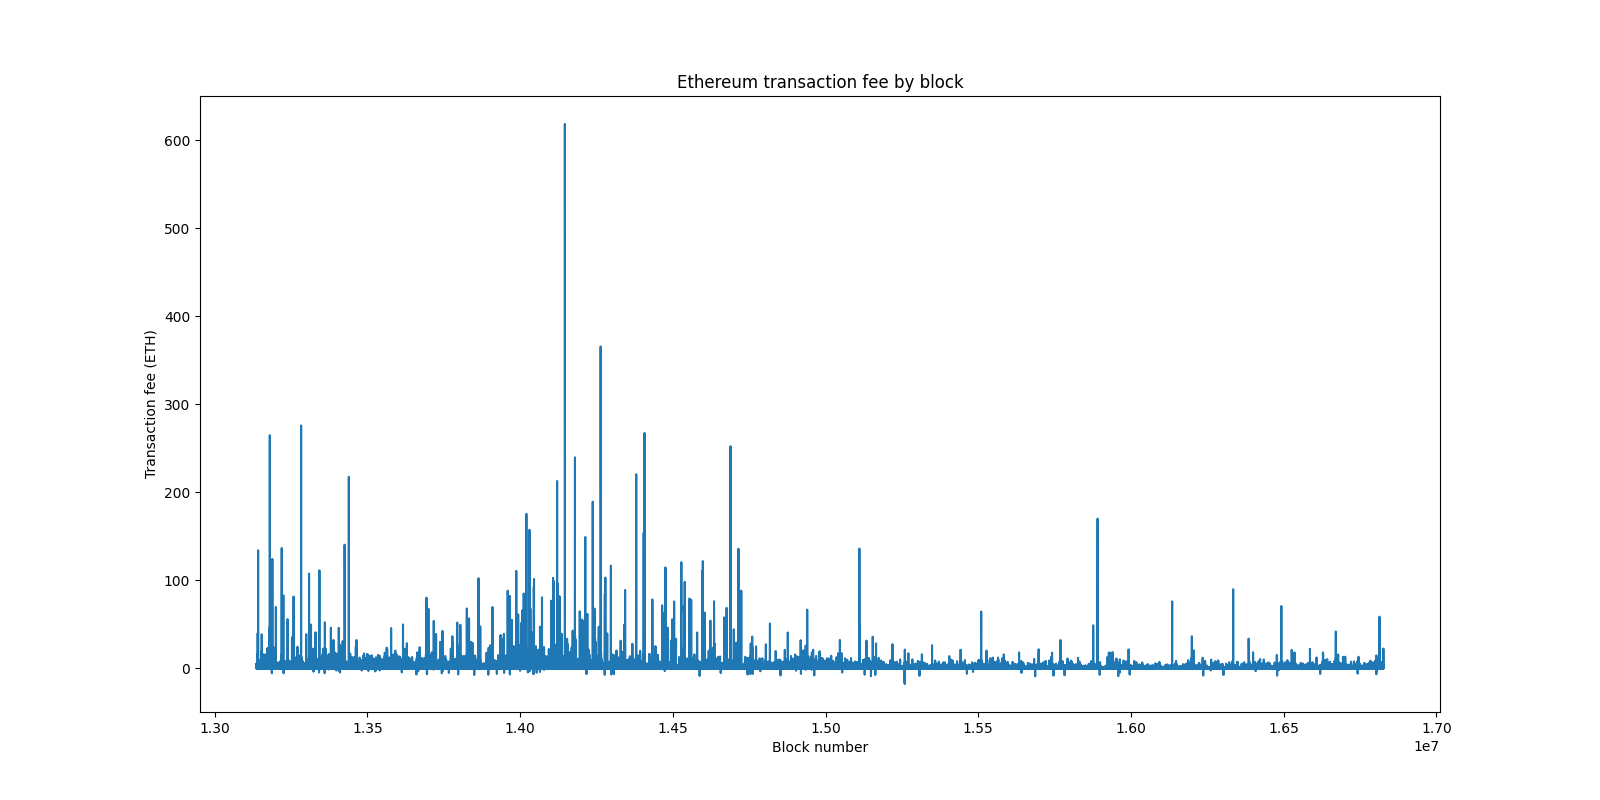

In [16]:
%matplot plt

In [17]:
df_daily_pd = df_daily.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
len(df_daily_pd)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

560

In [19]:
plt.figure(figsize=(16,8))
plt.plot(df_daily_pd['date'], df_daily_pd['txn_fee'])
plt.title("Ethereum transaction fee by date")
plt.xlabel("Date")
plt.ylabel("Transaction fee (ETH)")
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

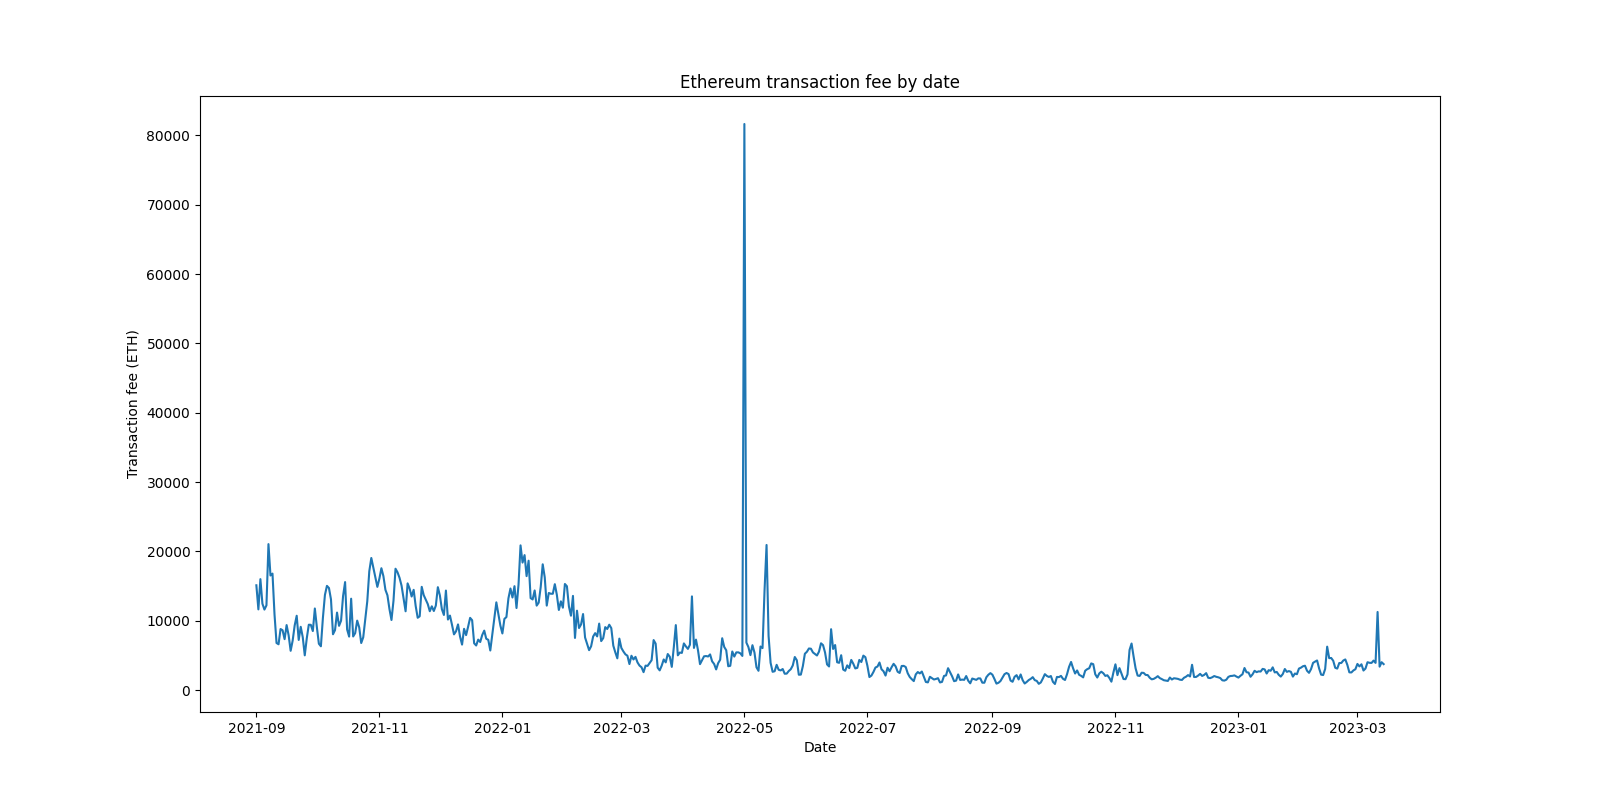

In [20]:
%matplot plt

By plotting the graphs, we see that while transaction fees on the block level has been noisy, especially before the merge, fees on the daily graph has been fairly stable.  
But what happened in May 2022? By doing some web search, I found that the spike in transaction fees was due to a newly launched NFT by Yoga Labs causing gas prices to spike to all time highs on May 1st, 2022. https://beincrypto.com/ethereum-gas-fees-spike-highs-latest-nft-hype/

In [21]:
# Average gas price over time
prices = raw.groupBy(['date']) \
            .avg('receipt_effective_gas_price') \
            .withColumnRenamed('avg(receipt_effective_gas_price)', 'avg_gas_price') \
            .sort('date')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
prices_pd = prices.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
plt.figure(figsize=(16,8))
plt.plot(prices_pd['date'], prices_pd['avg_gas_price'])
plt.title("Ethereum average gas price by date")
plt.xlabel("Date")
plt.ylabel("Gas price (wei)")
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

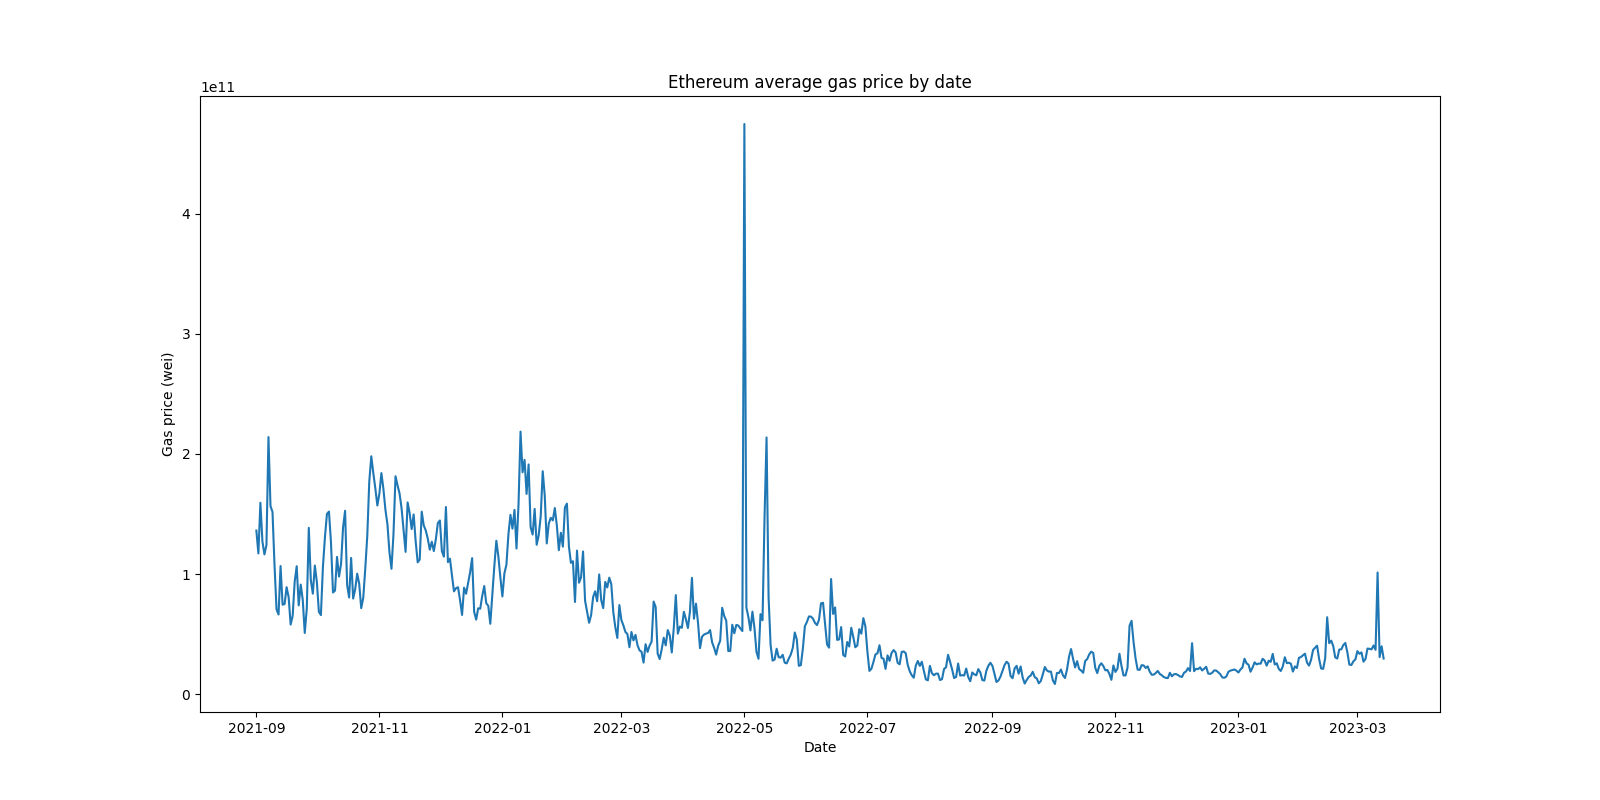

In [24]:
%matplot plt

The gas prices chart moves more than the transaction fee chart. This can be explained by elastic demand for transactions in response to gas prices - when prices are higher less transactions are made. Therefore the series for transaction fee is smoother.

# Testing for time series
I conduct a stationarity test and a serial correlation test on the txn_fee column.

In [45]:
# JupyterHub on EMR does not allow direct import so I copied the following code from time_series_tests.py. 
# Code is modified from my own code written for an econometrics class.

"""
This file implements three functions used for time series tests:
Correlogram, Ljung_Box_Q_test, and Check_Stationarity
"""

import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt


def autocov(z, j):
    """
    autocovariance function of j-th order
    z: data series (array)
    j: order
    """
    n = len(z)
    z_mean = np.mean(z)

    gamma = 0.0
    for t in range(j,n):
        gamma += (z[t] - z_mean) * (z[t-j] - z_mean)
    gamma = gamma/n

    return gamma


def autocorr(z, j):
    """"
    autocorrelation function of j-th order
    z: data series (array)
    j: order
    """
    gamma_0 = autocov(z,0)
    gamma_j = autocov(z,j)
    rho = gamma_j / gamma_0

    return rho


# Correlogram
def Correlogram(z, max_lag=40, plot=False):
    # z: data series
    # max_lag: number of lags
    correlogram = []
    for j in range(max_lag+1):
        rho_j = autocorr(z,j)
        correlogram.append(rho_j)

    # stderr
    N = len(z)
    stderr = 1 / np.sqrt(N)

    # plot correlogram
    if plot:
        plt.figure(figsize=(20,8))
        plt.plot(range(max_lag+1), correlogram, "o-")
        plt.axhline(2*stderr, ls="--", label='two std errs')
        plt.axhline(-2*stderr, ls="--")

        plt.title("Correlogram", fontsize=20)
        plt.xlabel("Lag")
        plt.ylabel("sample correlation coefficient")
        plt.legend(fontsize=20)
        plt.show()
    
    return correlogram, stderr


def Ljung_Box_Q_test(z,j):
    """
    Computes the Ljung-Box Q statistic 
        and the p-value basd on the Q test
    See reference: Fumio Hayashi (2011) Econometrics Ch. 2.10
    z: data series (array)
    j: order
    """
    n = len(z)
    q = 0.0
    for i in range(1,j+1):
        q += autocorr(z,i)**2 / (n-i)
    q = q * n *(n+2)

    # Q-stat asympototically converges to chi-square distribution
    p = 1 - sts.chi2.cdf(q, j)

    return q, p


from statsmodels.tsa.stattools import adfuller

def Check_Stationarity(z):
    """
    Performs Augmented Dickey-Fuller's test
    z: data series (array)
    """
    
    test_result = adfuller(z)
    print("ADF Statistic : %f \n" %test_result[0])
    print("p-value : %f \n" %test_result[1])
    print("Critical values are: \n")
    print(test_result[4])

    return test_result

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# extract data series as array
series_daily = df_daily_pd['txn_fee'].values

# Stationarity test with Augmented Dickey-Fuller
print("Augmented Dickey-Fuller testing results")
print("frequency=daily:")
ADF_results_daily = Check_Stationarity(series_daily)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Augmented Dickey-Fuller testing results
frequency=daily:
ADF Statistic : -2.293400 

p-value : 0.174105 

Critical values are: 

{'1%': -3.4423174665535385, '5%': -2.866818952732754, '10%': -2.569581505602171}

The ADF test statistic suggests that the data series is close to stationary, but not exactly.

In [46]:
# Sample autocorrelation with Correlogram
demeaned = series_daily - np.mean(series_daily)
correlogram, stderr = Correlogram(demeaned, max_lag=40, plot=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

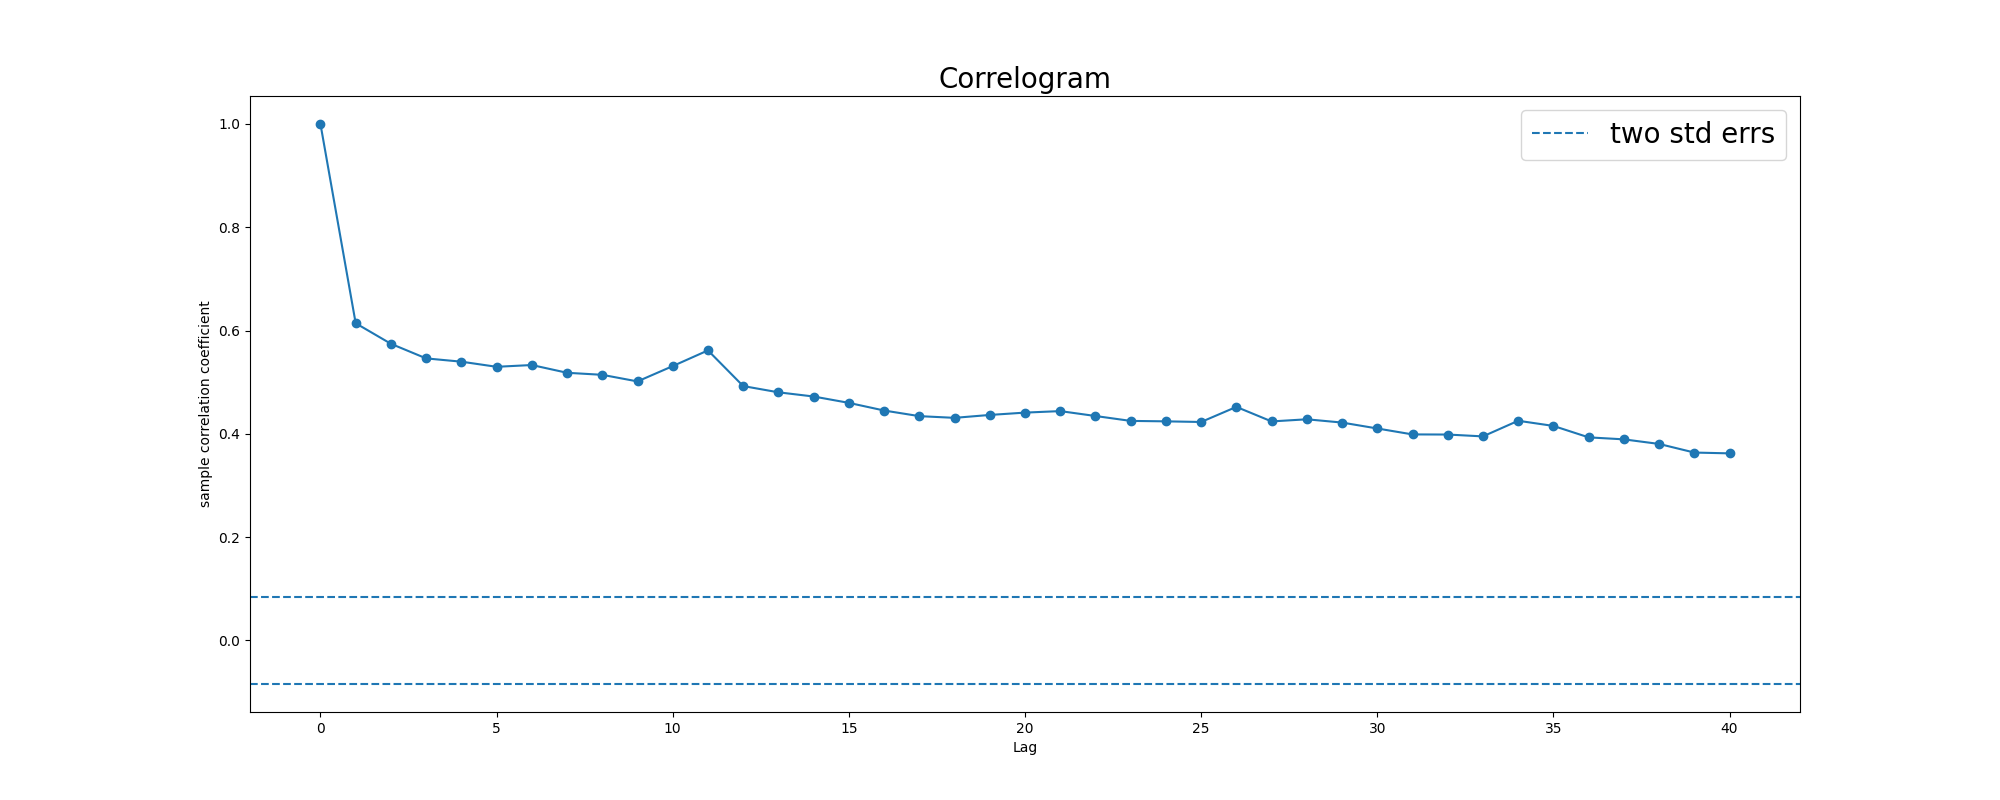

In [47]:
%matplot plt

The correlogram shows there is significant sample autocorrelation. Let's formalize using the Ljung-Box Q test.

In [48]:
# Ljung-Box Q test

# daily frequency
max_order_daily = 40
Qtest_pval_daily = []
print("Ljung-Box Q testing results")
print("frequency=daily:")
for order in range(1, max_order_daily):
    q, p = Ljung_Box_Q_test(series_daily, order)
    print(f"Lag: {order}, Q statistic: {q}, p value: {p}")
    Qtest_pval_daily.append(p)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Ljung-Box Q testing results
frequency=daily:
Lag: 1, Q statistic: 212.34017225797706, p value: 0.0
Lag: 2, Q statistic: 398.40043002955946, p value: 0.0
Lag: 3, Q statistic: 566.8822342413159, p value: 0.0
Lag: 4, Q statistic: 731.7640630183427, p value: 0.0
Lag: 5, Q statistic: 890.9232986158576, p value: 0.0
Lag: 6, Q statistic: 1052.4410776598195, p value: 0.0
Lag: 7, Q statistic: 1205.2710572348165, p value: 0.0
Lag: 8, Q statistic: 1356.042035080581, p value: 0.0
Lag: 9, Q statistic: 1499.6794709357262, p value: 0.0
Lag: 10, Q statistic: 1661.1058361378193, p value: 0.0
Lag: 11, Q statistic: 1841.8816507315903, p value: 0.0
Lag: 12, Q statistic: 1981.1757050745086, p value: 0.0
Lag: 13, Q statistic: 2113.9420482959167, p value: 0.0
Lag: 14, Q statistic: 2242.4954950548236, p value: 0.0
Lag: 15, Q statistic: 2364.652994721136, p value: 0.0
Lag: 16, Q statistic: 2479.2796355072455, p value: 0.0
Lag: 17, Q statistic: 2588.5654825802712, p value: 0.0
Lag: 18, Q statistic: 2696.3889652

The Ljung-Box Q test suggests significant serial correlation, indicating the neccessity to use autoregression methods in the modeling process.